# ML Project: Stock predictions Using LSTM(Long Short Term Memory) Model

In [4]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
plt.style.use ('fivethirtyeight')


2024-07-25 19:47:23.314782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import the Data:
##### Using the yfinance API we can import some historical stock data, and then use this data to create a model and make predictions. 

In [5]:
#Getting the stock 
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2019, 12,17)
apple_data = yf.Ticker('AAPL')
df = apple_data.history(start = start, end= end)
pd.DataFrame(df)
df = df.reset_index()
df.head(100)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-03 00:00:00-05:00,12.361729,12.455332,12.349651,12.416985,302220800,0.0,0.0
1,2012-01-04 00:00:00-05:00,12.379846,12.521158,12.358106,12.483716,260022000,0.0,0.0
2,2012-01-05 00:00:00-05:00,12.529306,12.638007,12.460462,12.622306,271269600,0.0,0.0
3,2012-01-06 00:00:00-05:00,12.674845,12.764825,12.658238,12.754257,318292800,0.0,0.0
4,2012-01-09 00:00:00-05:00,12.847860,12.915797,12.722551,12.734025,394024400,0.0,0.0
...,...,...,...,...,...,...,...,...
95,2012-05-18 00:00:00-04:00,16.122782,16.408122,15.767089,16.014685,732292400,0.0,0.0
96,2012-05-21 00:00:00-04:00,16.139087,16.955552,16.125498,16.947701,631106000,0.0,0.0
97,2012-05-22 00:00:00-04:00,17.197410,17.328154,16.685007,16.817562,694870400,0.0,0.0
98,2012-05-23 00:00:00-04:00,16.833572,17.295553,16.704641,17.227917,584897600,0.0,0.0


##### Now that we have the data we can do some cleaing that will make it easier to read and visualize the data later on.

In [6]:
#clean the date data to have only the day
type(df['Date'][0])
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date


In [7]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-03,12.361729,12.455332,12.349651,12.416985,302220800,0.0,0.0
1,2012-01-04,12.379846,12.521158,12.358106,12.483716,260022000,0.0,0.0
2,2012-01-05,12.529306,12.638007,12.460462,12.622306,271269600,0.0,0.0
3,2012-01-06,12.674845,12.764825,12.658238,12.754257,318292800,0.0,0.0
4,2012-01-09,12.847860,12.915797,12.722551,12.734025,394024400,0.0,0.0
...,...,...,...,...,...,...,...,...
1997,2019-12-10,65.247800,65.604890,64.582199,65.218651,90420400,0.0,0.0
1998,2019-12-11,65.298838,65.855123,65.223534,65.774956,78756800,0.0,0.0
1999,2019-12-12,65.048629,66.209777,64.936889,65.942566,137310400,0.0,0.0
2000,2019-12-13,65.942545,66.875349,65.813798,66.838913,133587600,0.0,0.0


### Visualizing the data

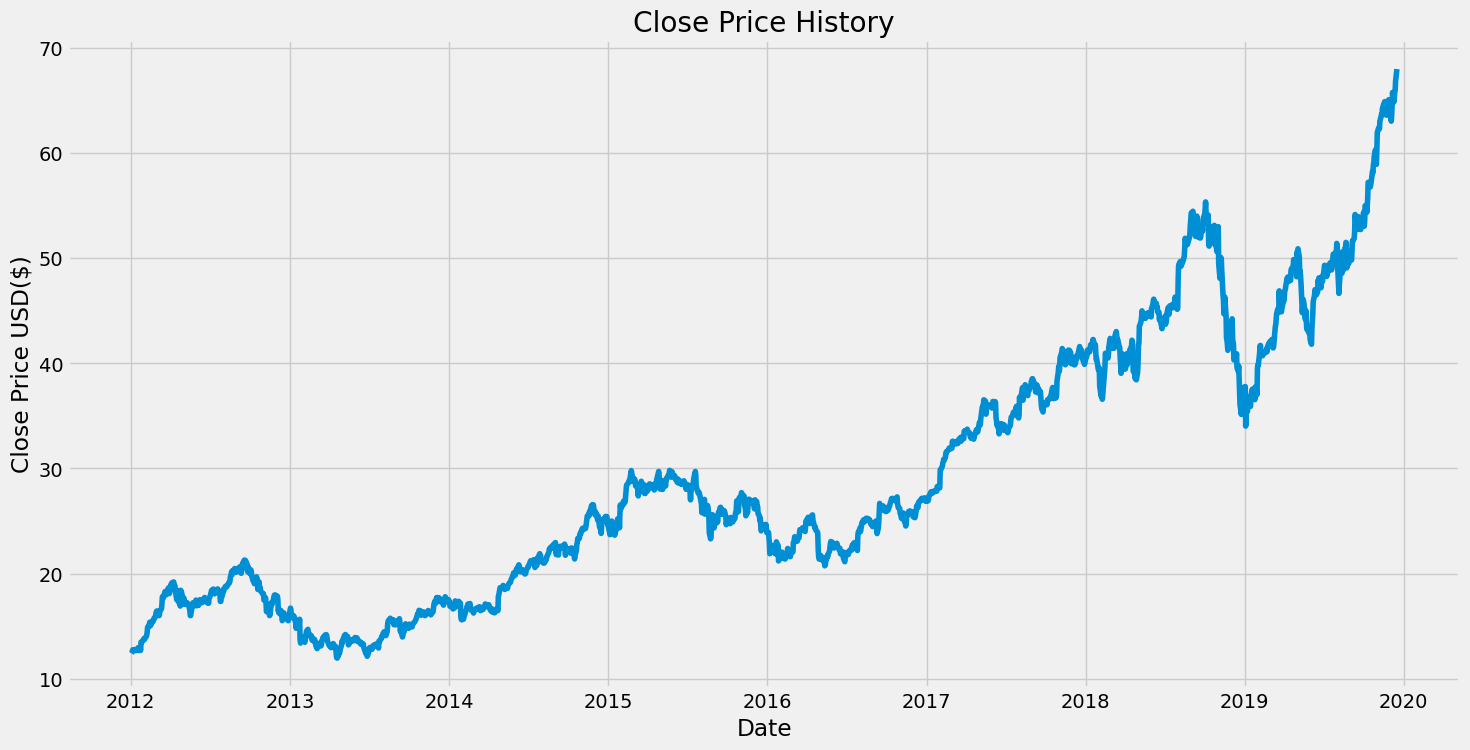

In [8]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df.Date,df.Close)
plt.xlabel('Date')
plt.ylabel("Close Price USD($)")
plt.show()

## Preparing the data for the model:
##### Since we have imported the data we need, done some cleaing, and visualization, we now need to pick which data to feed the model and prepare that data to get the optimal performace 

In [9]:
#Creating a new df with the close price only
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on (80% of data)
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1602

## Scaling the data: 
##### This is good practice to do, preprocessing, scaling, or normailzing the data before presenting the data to the model.

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00805078],
       [0.00924205],
       [0.01171611],
       ...,
       [0.96357339],
       [0.97957471],
       [1.        ]])

## Creating the Training Data Set:
##### Using a for loop, we can create 60-day time steps with corresponding y-values. The code [i-60:i, 0] is used for x-values, and [i, 0] is used for y-values. Starting from day 60, we get the x-values for days 0 to 59 and the y-value for day 60 based on the given data. This process trains the model to predict the closing price on the 61st day using data from the previous 60 days.

In [45]:
#Create the scaled trianing data set
train_data = scaled_data[0:training_data_len, :]
#spiltig the data into x_train and y_train
x_train= [] #indenpendent variable / features
y_train = [] #dependent/ target

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<= 60:
        print(x_train)
        print(y_train)
        print()



[array([0.00805078, 0.00924205, 0.01171611, 0.01407167, 0.01371049,
       0.01452449, 0.01415255, 0.01352729, 0.01267564, 0.01531144,
       0.01768857, 0.0169555 , 0.01293973, 0.01677221, 0.01299901,
       0.02714847, 0.02605427, 0.0274827 , 0.03057134, 0.03244174,
       0.03228537, 0.03170865, 0.03416665, 0.03647905, 0.03909877,
       0.04333015, 0.05221866, 0.05235339, 0.05730166, 0.06099941,
       0.05464432, 0.05709142, 0.057043  , 0.06390484, 0.06292901,
       0.06473475, 0.06797981, 0.06978557, 0.07498727, 0.07877652,
       0.07987077, 0.08025348, 0.07377429, 0.07221111, 0.07244303,
       0.07853392, 0.08024817, 0.08392973, 0.09260804, 0.10418631,
       0.1020194 , 0.10202471, 0.110396  , 0.11301556, 0.11115057,
       0.10944711, 0.10767378, 0.11356532, 0.11760811, 0.11930057])]
[0.11511777011741597]



##### Coverting the X and Y Into a Numpy Array:

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

## Reshape the Data:
##### We need reshape the data because an LSTM model, like many others, expects an input to be 3 diminsional interms of steps, samples, and features . Our X train is currently 2 dimensional.

In [13]:
x_train.shape ## 2D

(1542, 60)

In [14]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape # now as 3d-- (Samples(1542),Steps(60), Feutures(Just one, Close price)

(1542, 60, 1)

## Lets Start Building the Model:
##### Using Sequential we can put together the architecture of the model, layer by layer in a straight forward way. As previously stated we will use a LSTM model, and in this model we start with 2 LSTM layers. The first layer understands the higher level patterns and second layer will look for more complex patterns in the data. Each of these layers has 50 neuron. The more neurons there are, the more the complex patterns will be caputured, however more neurons increaes the risk of overfitting and computational cost if that is a concern. The Dense layer with 25 neurons combines and refines the features learned by the LSTM layers. This layer helps in extracting non-linear relationships from the features provided by the LSTM layers. The next dense layer with one neuron produces the output.

In [15]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))# LSTM layer with 50 neurons, true return seq to add more LSTM layers
model.add(LSTM(50,return_sequences=False,))
model.add(Dense(25))# densly connected 25 neurons
model.add(Dense(1))

/opt/miniconda3/envs/pydata-book/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the Model:

In [16]:
model.compile(optimizer= 'adam',loss= "mean_squared_error")#Optimizer is used to improve upon the loss funcation and loss function measures the how good the model is

### Train the model:
##### Batch size is the training examples in single forward and backward pass through the network, epoch is number of itterations when a entire dataset is passed foward and backward through the neural network or, the number of times a data set is used to train the model. More pass throughs will increase learning, but again risks overfitting.

In [17]:
model.fit(x_train, y_train, batch_size=1, epochs=1) 

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 0.0011


## Creating the testing data set:
##### Similar to how we made the training set, we will start the x_test data at the length of the training data minus 60, and then the x_test set will be appended in a similar way as before. This allows us to start 60 points behind and predict the 61st value. The y_test will be the entire dataset starting from the training data length, and will be used to compare the real values to the predicted values. After reshaping, the X values are fed to the model as an array with 60 time steps, a number of samples and in this case 1 feature. This information is used to predict the 61st value in each case. 

In [19]:
#create a new array containing scaled values from index 1542 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test= dataset[training_data_len:, :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [20]:
#Convert the data to a numpy array 
x_test = np.array(x_test)

In [26]:
len(test_data)

460

In [47]:
#reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

### Get the Models Predictions:

In [23]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)# this does the opposite of the scaling from eariler

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


## Judging the Model: 
##### By getting the Root Mean Sqaured Error(RMSE) we can judge the performance of the model.RSME tells us the average of the squared differences between the actual and the predicted values. The lower this value the better.

In [24]:
#getting the Root mean sqaured erros(RMSE) -- indictes how well the model performs, the lower the better
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.438546838760376

## Visualizing the Predictions VS Actual Prices
##### By graphing the actual values next to the predictions we can get a better understanding of how the model did.

/var/folders/nn/9kz8gxh905dddp63xswjzyn40000gn/T/ipykernel_6282/3627244654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = df['Date']
/var/folders/nn/9kz8gxh905dddp63xswjzyn40000gn/T/ipykernel_6282/3627244654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Date'] = df['Date']
/var/folders/nn/9kz8gxh905dddp63xswjzyn40000gn/T/ipykernel_6282/3627244654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

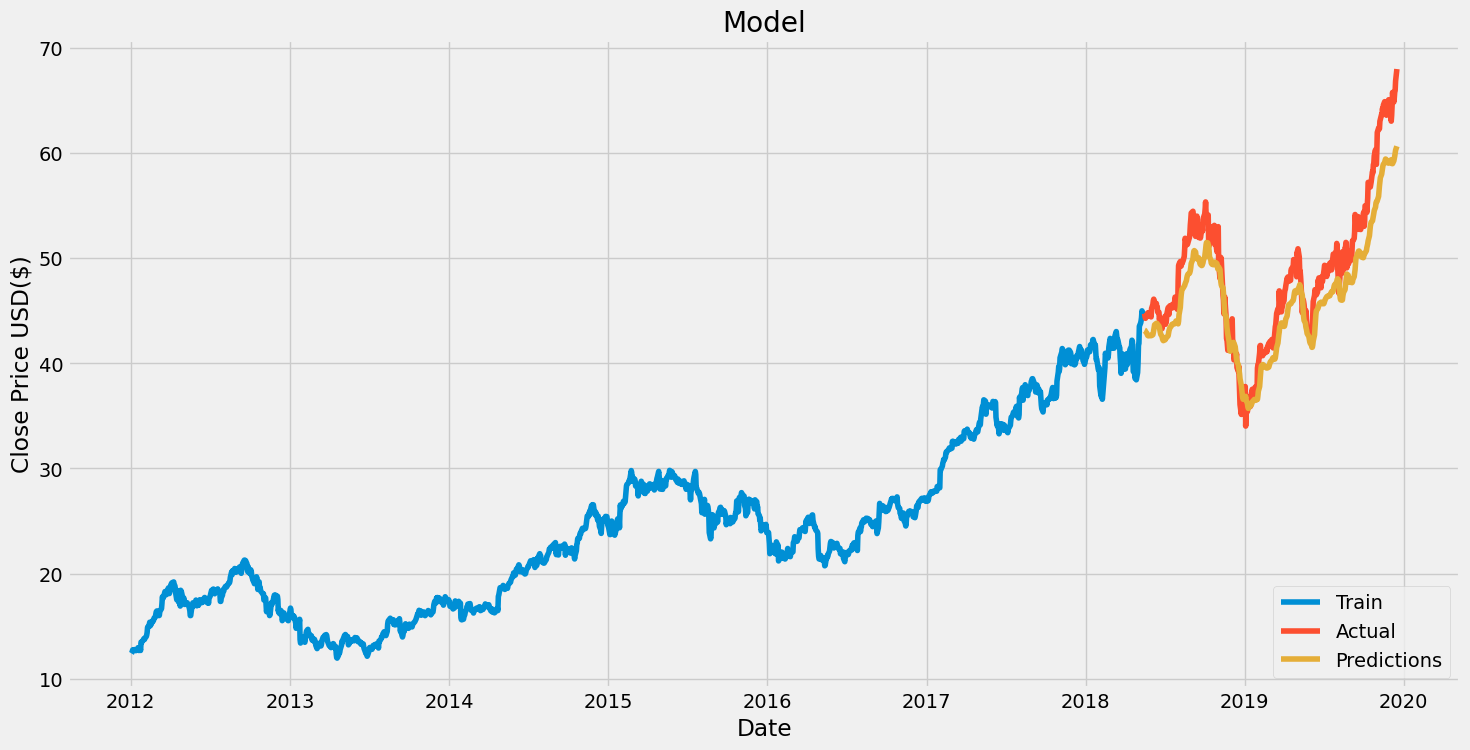

In [48]:
#Plot the data
train = data[:training_data_len]
train['Date'] = df['Date']
actual = data[training_data_len:]
actual['Date'] = df['Date']
actual['Predictions'] = predictions
#Vizulatize the data
plt.figure(figsize= (16,8))
plt.title('Model Predicted Price Vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price USD($)')
plt.plot(train['Date'],train['Close'])
plt.plot(actual['Date'],actual[['Close','Predictions']])
plt.legend(['Train','Actual','Predictions'],loc = 'lower right')
plt.show()

### Lets see a numerical comparison of the predictions and actual

In [49]:
actual

,Close,Date,Predictions
1602,44.722233,2018-05-16,43.145023
1603,44.439423,2018-05-17,43.125008
1604,44.277817,2018-05-18,43.027630
1605,44.591522,2018-05-21,42.876274
1606,44.479836,2018-05-22,42.760780
...,...,...,...
1997,65.218651,2019-12-10,59.469139
1998,65.774956,2019-12-11,59.696907
1999,65.942566,2019-12-12,59.978500
2000,66.838913,2019-12-13,60.263325


### Getting a Prediction for the First Day Outside of the Used Data:
##### After loading more stock data we can make a prediction outside of the data used and compare it to the actual price to once again see how well the model works.

In [38]:
#See if we can predict closing price for the 12/18/19, the day after our data set
#Get a Quote
apple_quote =  apple_data.history(start = start, end= end)
new_df = apple_quote.filter(['Close'])
#get the last 60 day closing price values and convert the DF to an array 
last_60 = new_df[-60:].values
#scale the data
last_60_scaled = scaler.transform(last_60)
newx_test = []
newx_test.append(last_60_scaled)
#Convert the test set to NP array 
newx_test =np.array(newx_test)
#reshape the data 
newx_test = np.reshape(newx_test,(newx_test.shape[0],newx_test.shape[1],1))
pred_price = model.predict(newx_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[61.16843]]


In [43]:
#getting the actual price of the next day to compare it to the predicted price of our model.
end2 = datetime.datetime(2019,12,19)
apple_quote2 =  apple_data.history(start = start, end= end2)
print(apple_quote2['Close'][-1])

67.95393371582031


/var/folders/nn/9kz8gxh905dddp63xswjzyn40000gn/T/ipykernel_6282/3004965246.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(apple_quote2['Close'][-1])
